In [214]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import pyspark
import matplotlib.pyplot as plt
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ravan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ravan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ravan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Preprocessing Text

## 1. Tokenize reviews into words remove stop words

In [3]:
def tokenize_sentences(x, tokenizer, stop_words):
    return [word.lower() for word in tokenizer.tokenize(x) if word.lower() not in stop_words and len(word) >=2]

raw_data = pd.read_csv("../amazon-product-ratings/product_rating.csv", index_col=0).dropna()
stop_words = set(stopwords.words('english')) 

# tokenize documents into sentences
my_tokenizer = RegexpTokenizer(r'\w+')
# data['reviews'] = data['reviews'].apply(lambda x: tokenize_sentences(x, my_tokenizer, stop_words))

## 2. Train a Doc2Vec model

In [29]:
from gensim.models.doc2vec import TaggedDocument
from gensim.models.doc2vec import Doc2Vec
from sklearn.model_selection import train_test_split

C:\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [7]:
reviews_tagged = [TaggedDocument(review, [i]) for i, review in enumerate(raw_data['reviews'])]
train_corpus, test_corpus, y_train, y_test = train_test_split(reviews_tagged, raw_data['ratings'].values, test_size=0.33, random_state=42)
# test_corpus = [x.words for x in test_corpus] # we only want words for test corpus

In [112]:
model = Doc2Vec(vector_size=100, min_count=1, epochs=40)
model.build_vocab(reviews_tagged)
model.train(reviews_tagged, total_examples=model.corpus_count, epochs=model.epochs)

# 3 Train a simple model

In [125]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling  import  RandomUnderSampler
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from collections import Counter

In [114]:
train_tags = [x.tags for x in train_corpus]
test_tags = [x.tags for x in test_corpus]

X_train = model[train_tags]
X_test = model[test_tags]

In [115]:
sampler = RandomUnderSampler()
X_train_res, y_train_res = sampler.fit_resample(X_train, y)
clf = AdaBoostClassifier()
clf.fit(X_train_res, y_train_res)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [124]:
sampler = RandomUnderSampler()
X_train_res, y_train_res = sampler.fit_resample(X_train, y)
clf = AdaBoostClassifier()
clf.fit(X_train_res, y_train_res)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [1]:
print(classification_report_imbalanced(clf.predict(X_test), y_test))

NameError: name 'classification_report_imbalanced' is not defined

# Feature Extraction

In [89]:
with open("../amazon-product-ratings/positive-words.txt") as f1:
    pos_words = f1.read().split('\n')
pos_words = pos_words[:-1]

with open("../amazon-product-ratings/negative-words.txt") as f2:
    neg_words = f2.read().split('\n')
neg_words = neg_words[:-1]

# Using Spark count sentimental words

In [5]:
from operator import add
rdd = sc.parallelize(raw_data['reviews'].dropna().values)
pos_words_count = rdd.map(lambda x: sum([1 for word in x.split(' ') if word in pos_words])).collect()
neg_words_count = rdd.map(lambda x: sum([1 for word in x.split(' ') if word in neg_words])).collect()

raw_data['pos_words_count'] = pos_words_count
raw_data['neg_words_count'] = neg_words_count
raw_data['review_length'] = raw_data['reviews'].apply(lambda x: len(my_tokenizer.tokenize(x)))

# Some Visulization
## We discvoer that in the reviews, sentiment words are highly correlated with the ratings

more negative words, means lower the ratings
more positive words, mean higher the ratings

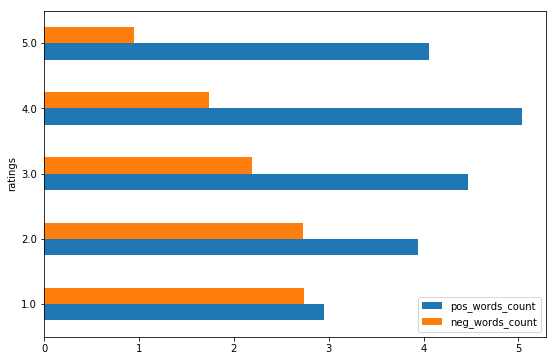

In [197]:

raw_data.groupby('ratings').agg({'pos_words_count': 'mean',
                                'neg_words_count': 'mean'}).plot(kind='barh', figsize=(9, 6))

# negation in the sentences should be taken care of!

"My little man got this for his first birthday along with the base. Now at 18 months he drags it back into the family room if we move it.  He loves his pony and will climb on and off all on his own whenever the mood strikes him. The base does make it very stable for younger kids and has not once tipped over. I have only had to add more air once to get the pressure back up, **not ** bad considering he has used it daily for half a year. We have the green with blue saddle and colors online are very true (assuming your monitor is).Rody has survived many a chomp on the ears and tail during rough teething times, but between us catching our little culprit and the thickness of the rubber it has not sustained any damage. Rody continues to look overjoyed to see our Son regardless of the abuse and I'm sure will be part of the family for a long time."

In [205]:
[word for word in my_tokenizer.tokenize(raw_data.loc[8781]['reviews']) if word in neg_words]

['drags', 'bad', 'rough', 'culprit', 'damage', 'abuse']

# Reviews length

It's reasonable to say, people tend to give longer reviews when they are angry or really hate the product, and tend to give shorter reviews when they are satisifed with the product

In [2]:
import seaborn
raw_data.groupby('ratings').review_length.median().plot()
plt.legend(["review length"])

ModuleNotFoundError: No module named 'seaborn'

# Train a simple model based on sentimental words count

In [3]:
features_data = raw_data[['pos_words_count', 'neg_words_count', 'review_length', 'ratings']]
X = features_data[['pos_words_count', 'neg_words_count', 'review_length']]
y = features_data['ratings']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

sampler = SMOTE(k_neighbors=4)
X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
clf = AdaBoostClassifier(n_estimators=200)
clf.fit(X_train_res, y_train_res)

mean_absolute_error(clf.predict(X_val), y_val)

NameError: name 'raw_data' is not defined

In [182]:
pipeline = Pipeline([('smote', sampler),
                     ('clf', clf)])

In [131]:
cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')

array([-1.14416189, -1.15292081, -1.1032208 , -1.11260038, -1.06489746])

In [183]:
cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')

array([-1.14768386, -1.07531118, -1.05841617, -1.01677662, -1.02432908])

In [198]:
clf.predict(X_val) - y_val

45212     0.0
104845    0.0
88975     1.0
8781     -3.0
129370   -2.0
83703    -2.0
33370     0.0
77370     0.0
78206    -1.0
46873    -4.0
90828     0.0
43145     1.0
118269    0.0
41516    -4.0
148319    0.0
26391     0.0
9218      0.0
79790     0.0
113117   -2.0
31774     0.0
136258   -4.0
137098   -2.0
114855   -1.0
43909     0.0
41705     0.0
9519      2.0
134442   -2.0
50576    -2.0
124866    1.0
104959    0.0
         ... 
136494   -1.0
98318     1.0
158929   -1.0
122895    0.0
55479    -1.0
34164     0.0
2405     -1.0
74422     0.0
129437    0.0
128391    0.0
149705    0.0
46460    -1.0
166229    3.0
123040    2.0
28034    -2.0
26180     1.0
119760    0.0
33782     2.0
55464     0.0
53198     0.0
71811    -1.0
41896     0.0
44186     0.0
52290    -1.0
86134    -1.0
391      -2.0
90394    -1.0
70076    -3.0
52890     0.0
161040   -1.0
Name: ratings, dtype: float64

In [147]:
raw_data